In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

def rough_plot(in_list, num_group):
    rough_list = list()
    tmp_sum = 0
    
    for i in range(1, len(in_list)):
        tmp_sum += in_list[i]
    
        if(i%num_group == num_group-1):
            rough_list.append(tmp_sum / num_group)
            tmp_sum = 0
            
    plt.plot(rough_list)

In [3]:
import sys

def next_state(state, action, action_level):
    next_state = state.copy()
    if (action > 2*action_level) or action < 0:
        print("action = ", action)
        sys.exit("error, action undefined! nxt")

    if action >= 1 and action <= action_level:
        # then buy
        
        if state['HandCash'] > 0:
            next_state['HandCash'] = state['HandCash']*(1 - action/action_level)
            next_state['NumStock'] = state['NumStock'] + \
                                     (state['HandCash']/state['StockPrice'])*(action/action_level)

    elif action >= (action_level + 1) and action <= (action_level + action_level) :
        # then sell
        
        if state['NumStock'] > 0:
            next_state['NumStock'] = state['NumStock']*(1 - (action-action_level)/action_level)
            next_state['HandCash'] = state['HandCash'] + \
                                     (state['StockPrice']*state['NumStock'])*((action-action_level)/action_level)
    
    return next_state


def reward(state, init_invest):
    return (state['NumStock']*state['StockPrice'] + state['HandCash']) - init_invest

def my_reward(curr, last):
    return (curr['NumStock']*curr['StockPrice'] + curr['HandCash']) - \
           (last['NumStock']*last['StockPrice'] + last['HandCash'])

In [4]:


def feature_5_conti(k_today, d_today, k_yestd, d_yestd, action, action_level):
    inter = (k_yestd+d_yestd+k_today+d_today)/4
    sinter = inter/100 # scaled inter
    if((k_yestd > d_yestd and k_today < d_today and inter > 50) or \
       (k_yestd < d_yestd and k_today > d_today and inter < 50)):
        # saction= sell all:1, sell:1~0.5, hold:0.5, buy:0.5~0, buy all:0
        # the diff btw saction & sinter(i.e. inter/100) : smaller is better(then return larger value)
        
        if(action <= action_level):
            saction = (action_level - action)/(2*action_level) # scaled action
        else:
            saction = action/(2*action_level)
            
        return 1-abs(sinter-saction)
        
    else: # best to hold
        if(action <= action_level): # hold
            return (action_level - action)/float(action_level)
        elif(action_level < action <= 2*action_level):
            return (2*action_level - action)/float(action_level)
    
# from feature_6_my  
def feature_5_dis(k_today, d_today, k_yestd, d_yestd, action, action_level):
    inter = (k_yestd+d_yestd+k_today+d_today)/4
    if(k_yestd < d_yestd and k_today > d_today and inter < 30): # buy
        if(action <= action_level):
            return (action + action_level)/float(2*action_level)
        elif(action_level < action <= 2*action_level):
            return (2*action_level - action)/float(2*action_level)
       
    elif(k_yestd > d_yestd and k_today < d_today and inter > 70): # sell
        if(action <= action_level):
            return (action_level - action)/float(2*action_level)
        elif(action_level < action <= 2*action_level):
            return (action)/float(2*action_level)
    else:
        if(action <= action_level): # hold
            return (action_level - action)/float(action_level)
        elif(action_level < action <= 2*action_level):
            return (2*action_level - action)/float(action_level)

In [5]:
from random import randint

def V_value(k_today, d_today, k_yestd, d_yestd, state,
            action_level):
    v = 0
    first = 1 # flag of the frist iteration
    v_act = ''
    for action in range(0, (2*action_level + 1)):
        
        # choose feature_5_conti or feature_5_dis here!!
        curr_q = feature_5_dis(k_today, d_today, k_yestd, d_yestd, action, action_level)
        
        if first == 1:
            first = 0
            v = curr_q
            v_act = action
        elif curr_q > v:
            v = curr_q
            v_act = action
        elif curr_q == v:
            flip = randint(0, 1)
            if flip == 1:
                v = curr_q
                v_act = action
    
    # add the if statement when u want to know the effective action. don't add when u want to know the intented action
    #if v == Q_value(k_today, d_today, k_yestd, d_yestd, price_list, state, 0, w, action_level):
        #v_act = 0
        
        
    #print("[v, v_act] = ", [v, v_act])
    return [v, v_act]

##### lists of data in each folder: copy and paste into the cell below
* ../input/  
inputFolderFormat = "../input/{0}"
inputCsvList = ['QCOM.csv', 'GOOG.csv', 'NOK.csv', '^DJI.csv', '^TWII.csv', 
           '^N225.csv', '^GDAXI.csv', '^IXIC.csv', '^KS11.csv', '^SSEC.csv', 
           'NSU.DE_10_5_5.csv', 'DAI.DE_10_5_5.csv', 'BMW.DE_10_5_5.csv', 
           '0050.TW.csv', '1216.TW.csv', '1301.TW.csv', '2002.TW.csv', 
           '2330.TW.csv', '2409.TW.csv', '2454.TW.csv', '1704.TW.csv']

* ../input/2001_2010/  
inputFolderFormat = "../input/2001_2010/{0}"
inputCsvList = ['QCOM.csv', 'NOK.csv', '^DJI.csv', '^TWII.csv', 
            '^N225.csv', '^GDAXI.csv', '^IXIC.csv', '^KS11.csv', 
            '^SSEC.csv', 'NSU.DE.csv', 'DAI.DE.csv', 'BMW.DE.csv']

In [6]:
from random import randint
import math
import stockstats

inputFolderFormat = "../input/{0}"
inputCsvList = ['QCOM.csv', 'GOOG.csv', 'NOK.csv', '^DJI.csv', '^TWII.csv', 
           '^N225.csv', '^GDAXI.csv', '^IXIC.csv', '^KS11.csv', '^SSEC.csv', 
           'NSU.DE_10_5_5.csv', 'DAI.DE_10_5_5.csv', 'BMW.DE_10_5_5.csv', 
           '0050.TW.csv', '1216.TW.csv', '1301.TW.csv', '2002.TW.csv', 
           '2330.TW.csv', '2409.TW.csv', '2454.TW.csv', '1704.TW.csv']


#relist = ['^IXIC.csv']

action_level = 3
last_rwd_func = reward
avg_point_rwd_func = my_reward

init_invest = 10000

kdallrwdlist = list() 

for resource_data in inputCsvList:

    input_csv = inputFolderFormat.format(resource_data)
    qcom = pd.read_csv(input_csv)
    qclose = qcom['Close']
    qclose = qclose.fillna(method='ffill')
    qclose = qclose.tolist()
    np.isnan(qclose).any()
    
    kdrwdlist = list()
    
    # preparing data for feature_5
    qcomStockStat = stockstats.StockDataFrame.retype(qcom)
    qcomStockStat[['kdjk','kdjd','kdjj']]
    qkdjk = qcomStockStat['kdjk'].tolist()
    qkdjd = qcomStockStat['kdjd'].tolist()
    
    
    # initial state
    state = {'NumStock': 0, 'StockPrice': qclose[0], 'HandCash': init_invest}

    for point in range(0, len(qclose)):

        # new price revealed!
        state['StockPrice'] = qclose[point]

        # prepare for the arguments passed later
        last_1_k = qkdjk[point-1]  
        last_1_d = qkdjd[point-1] 
        last_2_k = qkdjk[point-2] 
        last_2_d = qkdjd[point-2] 
        now_k = qkdjk[point]
        now_d = qkdjd[point]


        # determine the next state
        act = (V_value(now_k, now_d, last_1_k, last_1_d, state, action_level))[1]
                
        state = next_state(state, act, action_level)
        
        #print(act)
        kdrwdlist.append(state['HandCash'] + state['StockPrice']*state['NumStock'] - 10000)
    kdallrwdlist.append(kdrwdlist)
    print(resource_data, last_rwd_func(state, init_invest))

QCOM.csv 1058.5495497310694
GOOG.csv 12298.21252565688
NOK.csv 2241.8376899534705
^DJI.csv 4407.374905915916
^TWII.csv 1212.2516329320024
^N225.csv 3978.4632803133954
^GDAXI.csv 4482.001454556845
^IXIC.csv 3978.8494810159264
^KS11.csv 1845.3062115639386
^SSEC.csv 2518.967240695165
NSU.DE_10_5_5.csv 1264.7564167939672
DAI.DE_10_5_5.csv 741.5539541712769
BMW.DE_10_5_5.csv 7775.212183121155
0050.TW.csv -65.62511036623255
1216.TW.csv 133.34687594748357
1301.TW.csv 1855.9474154027957
2002.TW.csv -1724.3799543670611
2330.TW.csv 3128.626418910668
2409.TW.csv 5718.33573980642
2454.TW.csv -2165.055476670236
1704.TW.csv 388.7713697673571


In [7]:
full_action = True  # if True: buy with all cash, sell all stock
init_invest = 10000
trial_range = 1
consrange = 20     # consecutive days max. in the prob conslist

conslist = list()
for i in range(0, consrange*2 + 1):
    conslist.append([0, 0])

allrwdlist = list() 
    
for resource_data in inputCsvList:
    
    for i in range(0, consrange*2 + 1):
        conslist[i][0] = 0
        conslist[i][1] = 0
    
    input_csv = inputFolderFormat.format(resource_data)
    data = pd.read_csv(input_csv)
    close = data['Close']
    close = close.fillna(method='ffill')
    close = close.tolist()
    np.isnan(close).any()
    
    rwdlist = list()
    
    for trial in range(0, trial_range):

        state = {'NumStock': 0, 'StockPrice': close[0], 'HandCash': init_invest}
        
        cn = 0 # consecutive day num

        for point in range(0, len(close)):
            
            state['StockPrice'] = close[point]
            
            if point == 0:
                cn = 1 # serve as stok price going up
            elif 1 <= cn <= consrange: # consequtive goes up
                if close[point] >= close[point - 1]:
                    conslist[cn][0] += 1
                    cn += 1
                else:
                    conslist[cn][1] += 1
                    cn = consrange + 1
            elif consrange+1 <= cn <= consrange*2: # consequtive goes down
                if close[point] < close[point - 1]:
                    conslist[cn][1] += 1
                    cn += 1
                else:
                    conslist[cn][0] += 1
                    cn = 1
            
            tmp = cn
            
            # ar: action ratio
            while(1):          
                if conslist[tmp][0] + conslist[tmp][1] > 0:
                    ar = conslist[tmp][0] / (conslist[tmp][0] + conslist[tmp][1]) # ar: prob of next price going up
                    break
                else:
                    tmp -= 1
                    if tmp == 0 or tmp == consrange:
                        ar = 0.5
                        break
                    
            if ar >= 0.5: # next price may go up, let's buy
                ar = (ar - 0.5)*2
                
                if full_action:
                    state['NumStock'] += state['HandCash'] / state['StockPrice']
                    state['HandCash'] = 0
                else:
                    state['NumStock'] += state['HandCash'] * ar / state['StockPrice']
                    state['HandCash'] *= 1 - ar
                
                
                
            else: # next price may go down, let's sell
                ar = 1 - ar # ar: prob of next price going down
                ar = (ar - 0.5)*2
                
                if full_action:
                    state['HandCash'] += state['NumStock'] * state['StockPrice']
                    state['NumStock'] = 0
                else:
                    state['HandCash'] += state['NumStock'] * ar * state['StockPrice']
                    state['NumStock'] *= 1 - ar
                
            rwdlist.append(state['HandCash'] + state['StockPrice']*state['NumStock'] - 10000)
        allrwdlist.append(rwdlist)
                
            #print(state)
            #print(point, ' :: ', conslist[1:15], '*****', conslist[consrange+1: consrange+15])
    print(resource_data, state['HandCash'] + state['StockPrice']*state['NumStock'] - 10000)
    #print(resource_data, state['HandCash'] + state['StockPrice']*state['NumStock'])
    #print(point, ' :: ', conslist[1:6], '*****', conslist[consrange+1: consrange+6])

    #rough_plot(sqld.last_reward, 2)

QCOM.csv -208.36337698962052
GOOG.csv 3889.2779069283715
NOK.csv 3249.4220154405157
^DJI.csv 4835.444050537835
^TWII.csv 5458.005990829355
^N225.csv 3957.6229048744535
^GDAXI.csv 3418.868813951578
^IXIC.csv 9780.145804881347
^KS11.csv 415.73085631980575
^SSEC.csv 4229.448064758815
NSU.DE_10_5_5.csv 3901.7833849934796
DAI.DE_10_5_5.csv 4846.821561110253
BMW.DE_10_5_5.csv 12298.879073512926
0050.TW.csv 4537.324919252511
1216.TW.csv 5889.479949548817
1301.TW.csv 3779.18064313148
2002.TW.csv -217.15544027144642
2330.TW.csv 7707.322088430545
2409.TW.csv -1864.1404060667492
2454.TW.csv 2785.9644177631617
1704.TW.csv 3287.541198198687


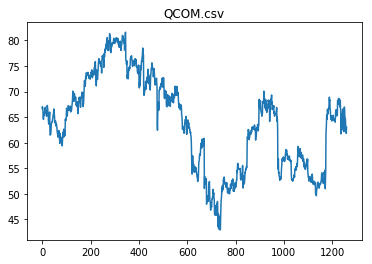

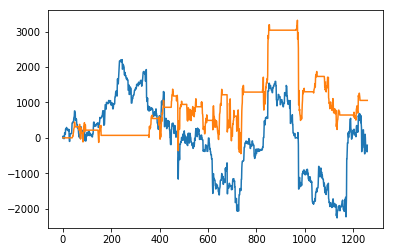

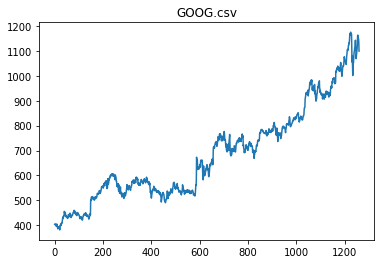

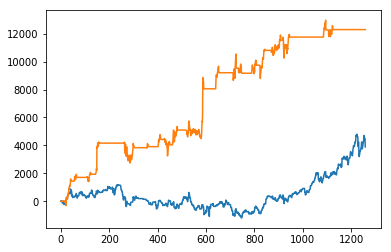

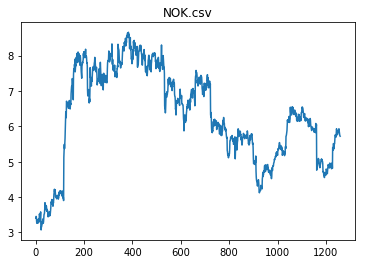

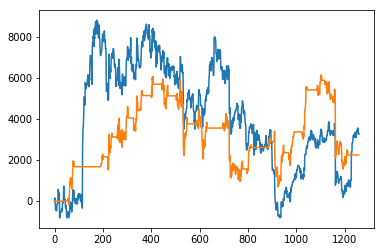

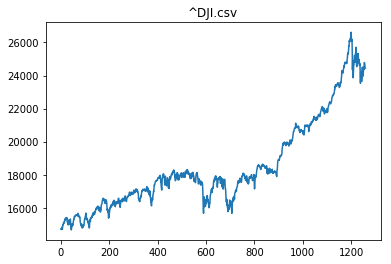

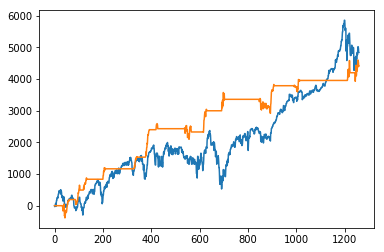

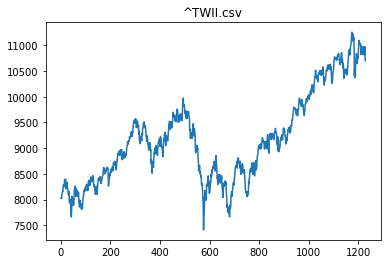

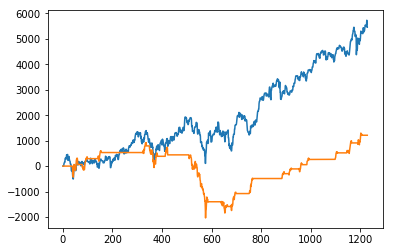

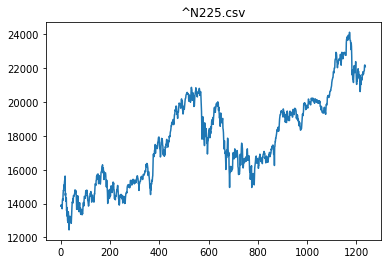

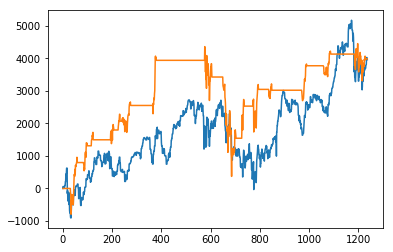

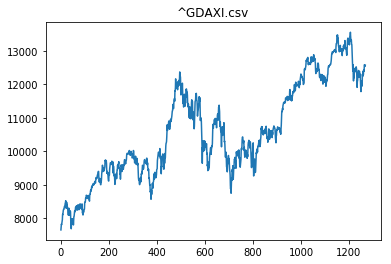

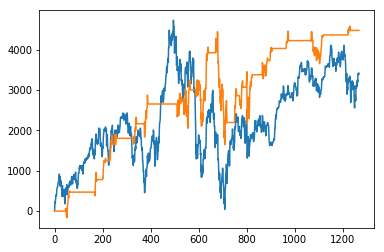

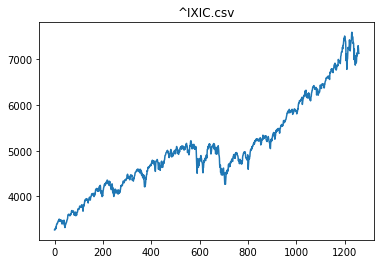

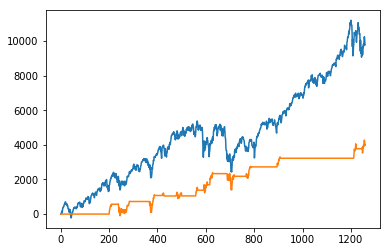

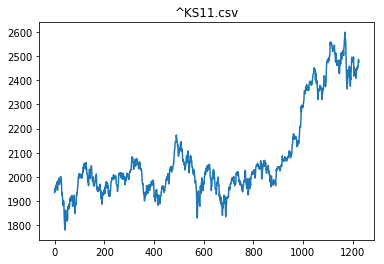

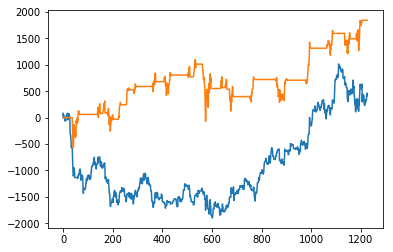

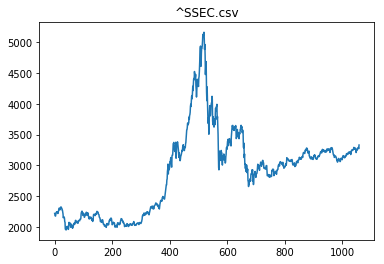

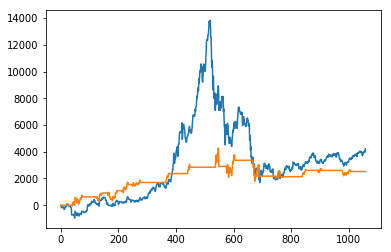

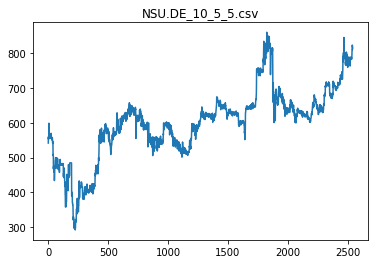

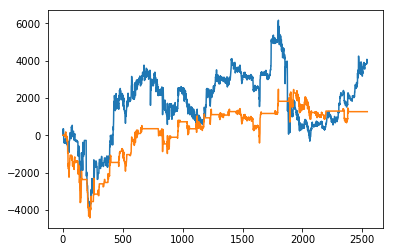

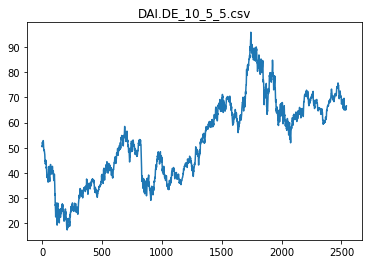

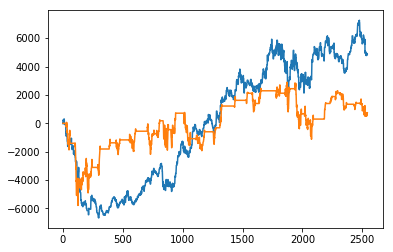

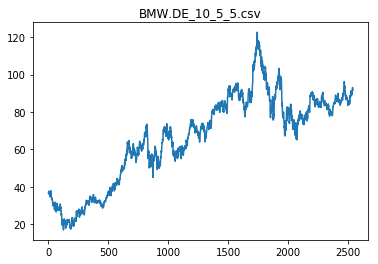

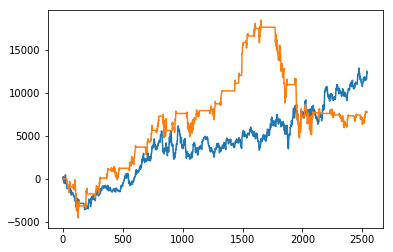

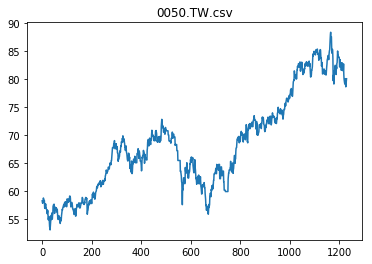

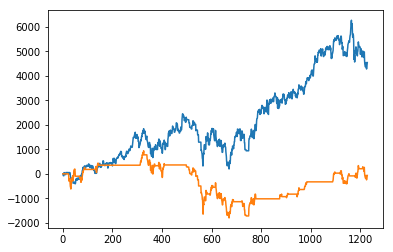

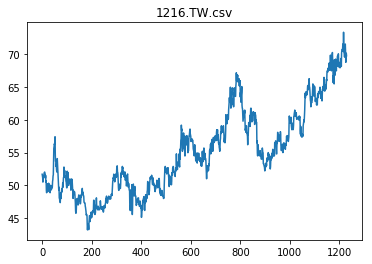

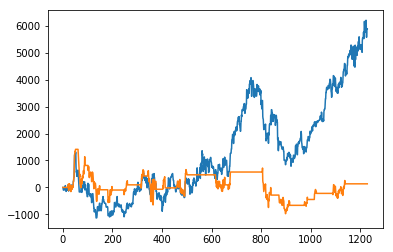

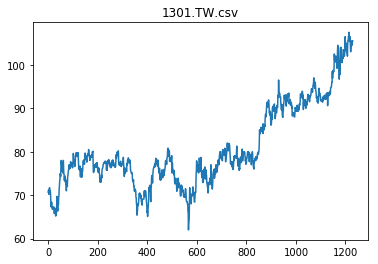

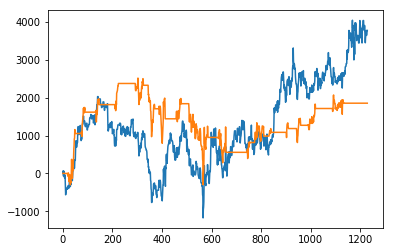

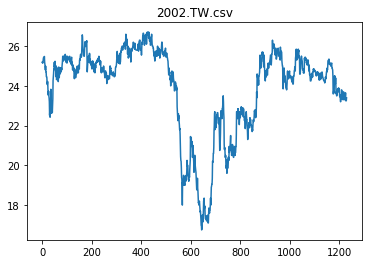

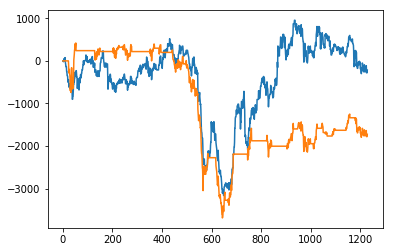

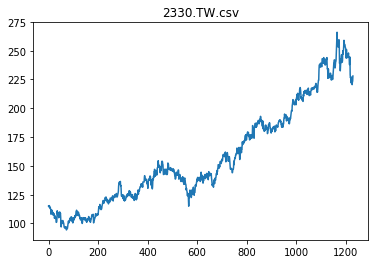

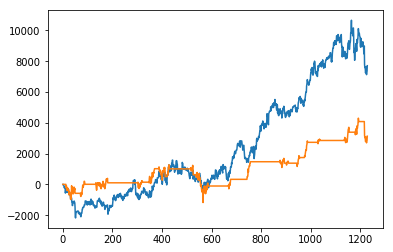

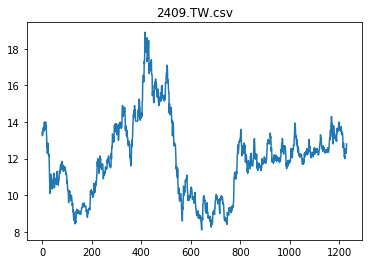

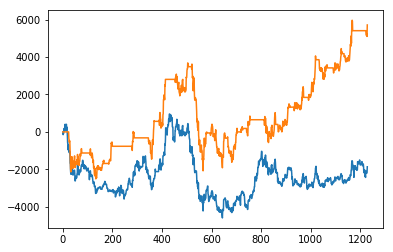

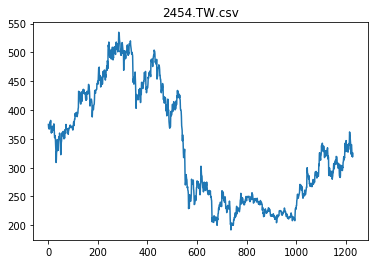

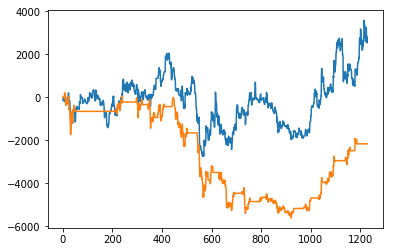

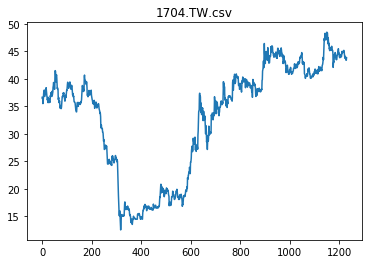

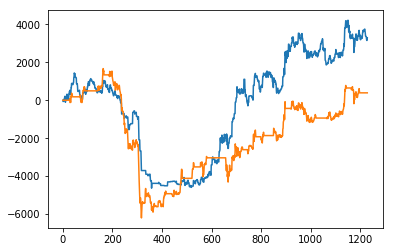

In [8]:
for i in range(0, len(inputCsvList)):
    input_csv = inputFolderFormat.format(inputCsvList[i])
    data = pd.read_csv(input_csv)
    close = data['Close']
    close = close.fillna(method='ffill')
    close = close.tolist()
    plt.title(inputCsvList[i])
    plt.plot(close)
    plt.show()
    plt.plot(allrwdlist[i])
    plt.plot(kdallrwdlist[i])
    plt.show()